In [11]:
from typing import Sequence, Tuple, List
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import cirq
from ansatz import CylicQAOAAnsatz, edge_operator, maxcut_hamiltonian

In [12]:
ps = range(1, 5)
f_max = []
for p in ps:
    print(f"p = {p}")
    qs = cirq.LineQubit.range(2 * p + 2)
    bitstring = [True] * len(qs)
    qubit_graph = nx.Graph()
    for i in range(len(qs) - 1):
        qubit_graph.add_edge(qs[i], qs[(i+1) % len(qs)])
    #hamiltonian = maxcut_hamiltonian(qubit_graph)
    observable = -1.0 * edge_operator(qs[p], qs[p+1])
    qaoa_ansatz = CylicQAOAAnsatz(qubit_graph, observable)

    def objective_callback(vars: np.ndarray):
        assert vars.size % 2 == 0
        
        gammas = vars[:(vars.size // 2)]
        betas = vars[(vars.size // 2):]
        return qaoa_ansatz.energy(gammas, betas)

    # Optimize the expectation value using Scipy's optimizer.
    gammas = np.random.rand(p)
    betas = np.random.rand(p)
    vars0 = np.concatenate((gammas, betas))
    opt_result = minimize(objective_callback, vars0, method="Nelder-Mead")
    assert opt_result.success, f"Optimizer failed: {opt_result.message}"
    f_max.append(objective_callback(opt_result.x))

df = pd.DataFrame({"p": ps, "f_max": f_max})
df.set_index("p", inplace=True)
print(df.head())

p = 1
p = 2
p = 3
p = 4
      f_max
p          
1 -0.750000
2 -0.833333
3 -0.875000
4 -0.875061


In [16]:
df.to_csv("cycle_maxima.csv")

In [17]:
def exact_f_max(p):
    """See section 4 of QAOA paper."""

    return (2 * p + 1) / (2 * p + 2)

exact_maxima = np.array([exact_f_max(p) for p in ps])

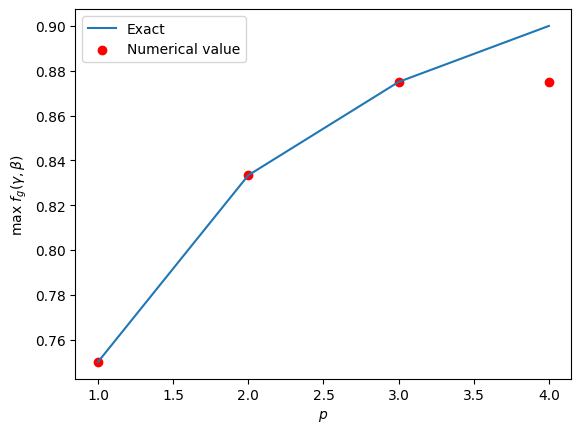

In [18]:
fig, ax = plt.subplots()
ax.plot(ps, exact_maxima, '-', label="Exact")
ax.scatter(ps, -1.0 * np.array(f_max), c="red", label="Numerical value")
ax.set_xlabel(r"$p$")
ax.set_ylabel(r"max $f_g(\gamma, \beta)$")
plt.legend()
plt.savefig("maxima.pdf")